# Tutorial 1b: *Global Visualizations*

This tutorial is an introduction to analyzing results from a global simulation.  It uses results from the case you ran in the 1a Tutorial, `Global_Simulations`, but do don't have to wait for those runs to complete before doing this tutorial too. We've prestaged model results from this simulation and another simulation using a different model configuration in a shared directory. This way, you can get started on analyzing simulations results before your simulations finish running and compare differences caused by model structure. 

## In this tutorial

The tutorial has several objectives: 
1. Become familiar with Jupyter Notebooks
2. Begin getting acquainted with python packages and their utilities
3. Compare results from two simulations, here CLM5.1-SP and CLM5.1_FATES-SP

***

<div class="alert alert-block alert-info">
<b>NOTE:</b> In this tutorial, you can directly execute the contents of code blocks by running individual cells in this Jupyter notebook, similar to the Day 0b <i>Run NEON</i> tutorial.
</div>

***
First we'll have a look at the data, 
- these were prestaged for your use in the tutorial, but should be idential to the FATESsp case you just ran 

In [1]:
!ls /scratch/data/day1/I2000_CTSM_FATESsp/lnd/hist/ |head -20

I2000_CTSM_FATESsp.clm2.h0.2000-01.nc
I2000_CTSM_FATESsp.clm2.h0.2000-02.nc
I2000_CTSM_FATESsp.clm2.h0.2000-03.nc
I2000_CTSM_FATESsp.clm2.h0.2000-04.nc
I2000_CTSM_FATESsp.clm2.h0.2000-05.nc
I2000_CTSM_FATESsp.clm2.h0.2000-06.nc
I2000_CTSM_FATESsp.clm2.h0.2000-07.nc
I2000_CTSM_FATESsp.clm2.h0.2000-08.nc
I2000_CTSM_FATESsp.clm2.h0.2000-09.nc
I2000_CTSM_FATESsp.clm2.h0.2000-10.nc
I2000_CTSM_FATESsp.clm2.h0.2000-11.nc
I2000_CTSM_FATESsp.clm2.h0.2000-12.nc
I2000_CTSM_FATESsp.clm2.h0.2001-01.nc
I2000_CTSM_FATESsp.clm2.h0.2001-02.nc
I2000_CTSM_FATESsp.clm2.h0.2001-03.nc
I2000_CTSM_FATESsp.clm2.h0.2001-04.nc
I2000_CTSM_FATESsp.clm2.h0.2001-05.nc
I2000_CTSM_FATESsp.clm2.h0.2001-06.nc
I2000_CTSM_FATESsp.clm2.h0.2001-07.nc
I2000_CTSM_FATESsp.clm2.h0.2001-08.nc


Each line of the list above includes the file path (`/scratch/data/day1/I2000_CTSM_FATESsp/lnd/hist/`) and file name. 
* The simulation you ran is really from an I2000 case, which means it just cycles over datm data from 1991-2000 with constant land cover, CO2, etc.  

These simulations generate one types of files:
* `*h0*`: Variables that are averaged monthly. One file is available for every month of the simulation.

****

The files are saved in netcdf format (denoted with the `.nc` file extension), a file format commonly used for storing large, multi-dimensional scientific variables.
Netcdf files are platform independent and self-describing; each file includes metadata that describes the data, including: **variables**, **dimensions**, and **attributes**.

The figure below provides a generic example of the data structure in a netcdf file. The dataset illustrated has two variables (temperature and pressure) that have three dimensions. Coordinate data (e.g., latitude, longitude, time) that describe the data are also included. 

*Note that while each file for FATES-SP simulations has multiple variables. Within each `h0` file, most of the variables have three dimensions (lat x lon x time), while a few soil variables (e.g., moisture, temperature) have 4 dimensions (lat x lon x time x depth).*

![Netcdf](https://xarray.pydata.org/en/stable/_images/dataset-diagram.png)
****


To dig deeper we'll use this notebook and some phthon packages to look at the data and make some simple plots

*We'll start by loading some packages*

In [2]:
# python packages
import xarray as xr
import numpy as np
import pandas as pd

# resources for plotting
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cftime
%matplotlib inline

<div class="alert alert-block alert-info">

<b>NOTE:</b>  This example largely uses features of xarray and 
    matplotlib packages. We won't go into the basics 
    of python or features included in these packages, but there are lots of 
    resources to help get you started. Some of these are listed below. 

</div>

- [NCAR python tutorial](https://ncar.github.io/python-tutorial/tutorials/yourfirst.html), which introduces python, the conda package manager, and more on github.
- [NCAR ESDS tutorial series](https://ncar.github.io/esds/blog/tag/python-tutorial-series/), features several recorded tutorials on a wide variety of topics.
- [Project Pythia](https://projectpythia.org/) links to lots of great resources!
- [GeoCAT examples](https://geocat-examples.readthedocs.io/en/latest/), with some nice plotting examples

***

## 1. Reading and formatting data

### 1.1 Point to the data

In [3]:
path = '/scratch/data/day1/'                     # path to archived simulations
cases = ['I2000_CTSM51_sp','I2000_CTSM_FATESsp'] # case names
years = list(range(2015,2020,1))                 # look at the last 5 years of data

# create a list of the files we'll open
# for now we'll create two different lists of files, one for each simulation that we'll compare 
finCTSM  = [path+cases[0]+'/lnd/hist/'+cases[0]+'.clm2.h0.'+str(year)+'*' for year in years] 
finFATES = [path+cases[1]+'/lnd/hist/'+cases[1]+'.clm2.h0.'+str(year)+'*' for year in years] 

# print the last year of data loaded
print(finCTSM[-1])
print(finFATES[-1])

/scratch/data/day1/I2000_CTSM51_sp/lnd/hist/I2000_CTSM51_sp.clm2.h0.2019*
/scratch/data/day1/I2000_CTSM_FATESsp/lnd/hist/I2000_CTSM_FATESsp.clm2.h0.2019*


<div class="alert alert-block alert-info">
<b>NOTE:</b> These are the raw history files that CTSM writes out.  
By default, they include grid cell averaged monthly means for different state and flux variables.
<br><br>
Typically we post-process these data to generate single variable time series for an experiment. 
This means that the full time series of model output for each variable, like rain, air temperature, or latent heat flux, are each in their own file.
A post-processing tutorial will be available at a later date, but for now we'll just read in the monthly history files described above.

</div>

### 1.2 Open files & load variables

This is done with the xarray function `open_mfdataset`

To make this go faster, we're going to preprocess the data so we're just reading the variables we want to look at.

<div class="alert alert-block alert-info">
    <b>TIP:</b> If you want to look at other variables, the <b>fields</b> variable in the cell below is where you can modify what we're reading off of the CTSM and CTSM-FATES history files.
</div>

Depending on what you're looking at, these variables of interest may have different names in CTSM and CTSM-FATES simulations.  While this is confusing, FATES-specific variables all have a *FATES_* prefix. This reflects if the history variables are being calculated by FATES directly, or uses information from FATES, but ultimately calculated by the host land model (here CTSM). 
    
To begin with we'll look at albedo that's simulated by the two models. 
Albedo and can be calculated in several different ways, but the calculations use solar radiation terms that are handled within CTSM.
Here we'll look at 'all sky albedo', which is the ratio of reflected to incoming solar radiation (**FSR/FSDS**).
Other intereresting variables might include latent heat flux or gross primary productivity. 
**Note,** we also include information about grid cell areas, as it's helpful for calculating globally weighted results. 

In [4]:
# Notes in your code are helpful to understand what's going on

# Define the variables to read in
fields = ['FSR','FSDS', 'ELAI','area','landfrac']

# Create some functions that help read in the data
''' quick fix to adjust time vector for monthly data'''
def fix_time(ds):  
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')    

    return ds

'''select the variables we want to read in'''
def preprocess(ds, fields=fields):
    return ds[fields]

# Open the datasets. Here we'll just read in a single year of data
dsCTSM = fix_time(xr.open_mfdataset(finCTSM[0], decode_times=True, 
                                    preprocess=preprocess))


# Define the variables to read in HINT, this may be useful for the extra cridit
# fields = ['FSR','FSDS', 'ELAI','area','landfrac']
# def preprocess(ds, fields=fields):
#    return ds[fields]
dsFATES = fix_time(xr.open_mfdataset(finFATES[0], decode_times=True, 
                                     preprocess=preprocess) )

print('-- your data have been read in --')

-- your data have been read in --


#### Printing information about the dataset is helpful for understanding your data. 
- *What dimensions do your data have?*
- *What are the coordinate variables?*
- *What variables are we looking at?*
- *Is there other helpful information, or are there attributes in the dataset we should be aware of?*

Keep in mind that we only read a single year of data, so the time dimension is in months.

In [5]:
# Print information about the dataset
dsFATES

<xarray.Dataset>
Dimensions:   (time: 12, lat: 46, lon: 72)
Coordinates:
  * time      (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon       (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat       (lat) float32 -90.0 -86.0 -82.0 -78.0 ... 78.0 82.0 86.0 90.0
Data variables:
    FSR       (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    FSDS      (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    ELAI      (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    area      (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
    landfrac  (time, lat, lon) float32 dask.array<chunksize=(1, 46, 72), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 04/26/22 13:39:22
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./I2000_CTSM_FATESsp.clm2.h0.2000-0...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

You can also print information about the variables in your dataset. The example below prints information about one of the data variables we read in. You can modify this cell to look at some of the other variables in the dataset.

*What are the units, long name, and dimensions of your data?*

In [6]:
dsFATES.FSDS

<xarray.DataArray 'FSDS' (time: 12, lat: 46, lon: 72)>
dask.array<concatenate, shape=(12, 46, 72), dtype=float32, chunksize=(1, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
Attributes:
    long_name:      atmospheric incident solar radiation
    units:          W/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

### 1.3 Combining datasets
Since our CTSM-FATESsp and CTSM5.1-SP **have the same variables**, we can: 
1. Combine them into a single dataset using the xarray function `concat` 
2. Assign coordinates to the ‘sim' dimension to allow sorting by simulation case

*Note that our new dataset is called* `ds`


In [7]:
ds = xr.concat([dsCTSM,dsFATES], 'sim', data_vars='all')
ds = ds.assign_coords(sim=("sim", ['CTSM5.1-sp','CTSM-FATESsp']))
ds.FSDS

<xarray.DataArray 'FSDS' (sim: 2, time: 12, lat: 46, lon: 72)>
dask.array<concatenate, shape=(2, 12, 46, 72), dtype=float32, chunksize=(1, 1, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * sim      (sim) <U12 'CTSM5.1-sp' 'CTSM-FATESsp'
Attributes:
    long_name:      atmospheric incident solar radiation
    units:          W/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

### 1.4 Adding derived variables to the dataset

Next we can calculate the all sky albedo (ASA). Remember from above that this is the ratio of reflected to incoming solar radiation (**FSR/FSDS**).
We will add this as a new variable in the dataset and add appropriate metadata.

*When doing calculations, it is important to avoid dividing by zero. Use the `.where` function for this purpose*

In [8]:
ds['ASA'] = ds.FSR/ds.FSDS.where(ds.FSDS>0)
ds['ASA'].attrs['units'] = 'unitless'
ds['ASA'].attrs['long_name'] = 'All sky albedo'

---
## 2. Plotting
### 2.1 Easy plots using Xarray
To get a first look at the data, we can plot a month of data from the two simulations, selecing the month using the `.isel` function.

<div class="alert alert-block alert-info">
    <b>NOTE:</b> The plotting function only works with 1D or 2D data. Our data are 4D (sim, time, lat, lon), so we need to specify a specific value for the other variables. Below, we select a specific time using the <i>isel</i> and specify that we want to plot both simulations as panels using <i>col="sim"</i>, leaving the lat and lon dimensions to plot on the x and y axes.
</div>

- We will plot all sky albedo (variable = `ASA`). Note that we select the variable by specifying our dataset, `ds`, and the variable. 
- The plot is for the month of June (`time=6`)
- This plotting function will plot `ASA` for each simulation in our dataset

*More plotting examples are on the [xarray web site](https://docs.xarray.dev/en/latest/user-guide/plotting.html)*

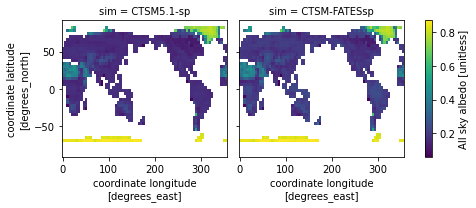

In [9]:
ds.ASA.isel(time=6).plot(x='lon',y='lat',col="sim", col_wrap=2) ;

We can also plot every month from the year of data we read from the files. Here we do that for a single simulation, specified by `(sim=0)`

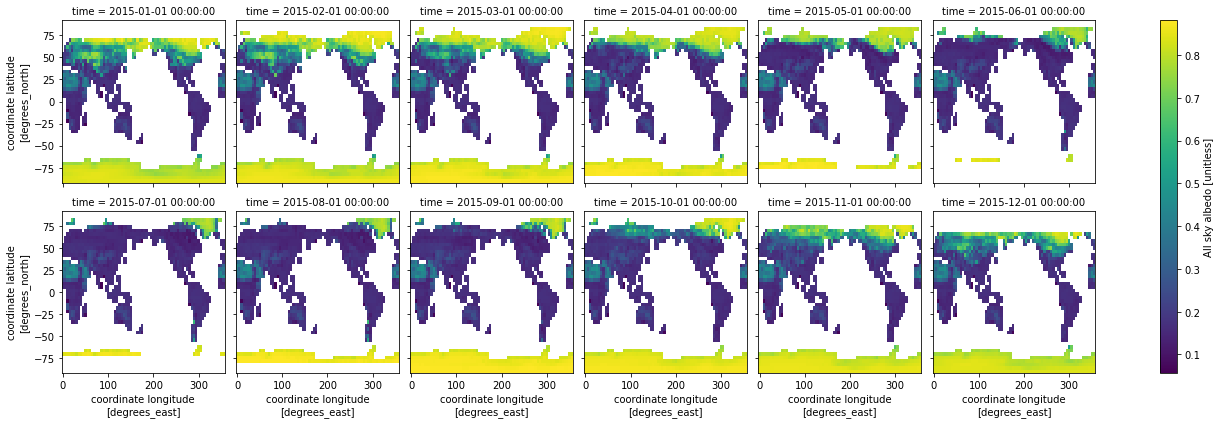

In [10]:
ds.ASA.isel(sim=0).plot(x='lon',y='lat',col="time", col_wrap=6) ;

**Question:** 
Why don't you see the whole globe in some months?

### 2.2 Calculating differences

In the previous section, it was difficult to see albedo differences between the simulations in side-by-side comparisons. We can calculate the differences between the simulations to more clearly see the differences and to understand how model structure, specifically the difference between CLM-FATESsp and CLM5.1sp, changes simulated albedo. The below code:
- Subtracts CLM5.1sp from CLM-FATESsp 
- Defines the difference as a new variable, `dsDiff`

We'll first plot maps of the difference in all sky albedo for each month

<xarray.Dataset>
Dimensions:   (sim: 2, time: 12, lat: 46, lon: 72)
Coordinates:
  * time      (time) object 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon       (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat       (lat) float32 -90.0 -86.0 -82.0 -78.0 ... 78.0 82.0 86.0 90.0
  * sim       (sim) <U12 'CTSM5.1-sp' 'CTSM-FATESsp'
Data variables:
    FSR       (sim, time, lat, lon) float32 dask.array<chunksize=(1, 1, 46, 72), meta=np.ndarray>
    FSDS      (sim, time, lat, lon) float32 dask.array<chunksize=(1, 1, 46, 72), meta=np.ndarray>
    ELAI      (sim, time, lat, lon) float32 dask.array<chunksize=(1, 1, 46, 72), meta=np.ndarray>
    area      (sim, time, lat, lon) float32 dask.array<chunksize=(1, 1, 46, 72), meta=np.ndarray>
    landfrac  (sim, time, lat, lon) float32 dask.array<chunksize=(1, 1, 46, 72), meta=np.ndarray>
    ASA       (sim, time, lat, lon) float32 dask.array<chunksize=(1, 1, 46, 72), meta=np.ndarray>
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 04/17/22 07:24:51
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./I2000_CTSM51_sp.clm2.h0.2000-01.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

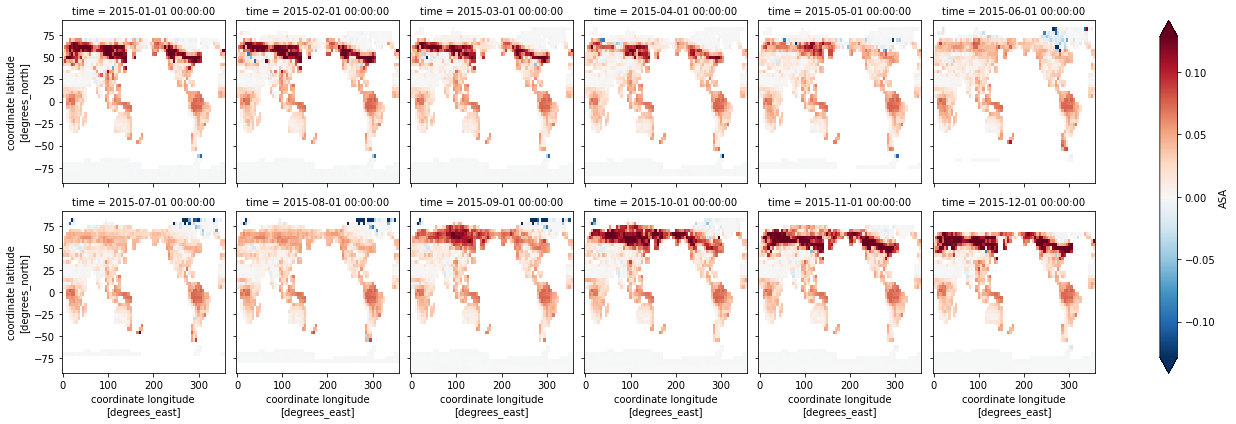

In [11]:
dsDiff = ds.sel(sim='CTSM-FATESsp') - ds.sel(sim='CTSM5.1-sp')
dsDiff.ASA.plot(x='lon',y='lat',col="time", col_wrap=6, robust=True) ;
ds

**Questions:** 
- How is albedo different in CTSM-FATESsp and CTSM5.1-sp?
- Where are the differences the largest? 
- Are the differences consistent throughout the year?
- Since these simulations have the same climate and LAI, what's driving the differences in albedo in different regions?

**What's causing these differences in SP mode?**
- CTSM and FATES use different radiation schemes (2-stream vs. Norman, respectively). 
- FATES doesn't simulate canopy interception of snow, leading to differences in the northern hemisphere in the winter.
- These differences are being actively investigated, you can see the conversation on [this FATES issue](https://github.com/NGEET/fates/issues/837).

<div class="alert alert-block alert-info">
<b>ISSUES:</b> CTSM and FATES model developers use GitHub issues to identify bugs, make model improvements, and track code developments.  You can watch these conversations, contribute to onging discussions, or create new issues when you find a problem with the model.
</div>



#### Are the differences coming from incoming or reflected radiation? 
To find out, we can plot each variable. First we will plot incoming radiation (the denominator in all-sky albedo).

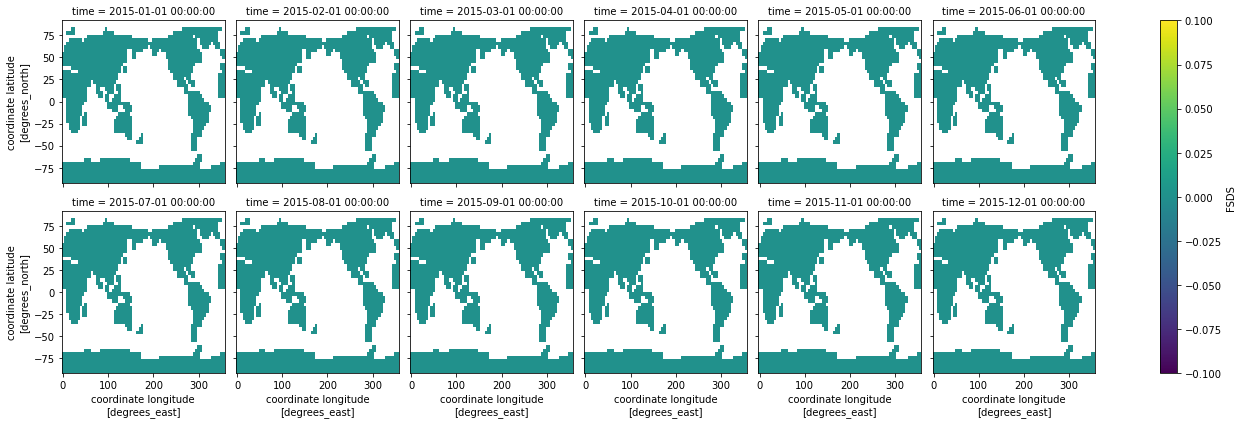

In [12]:
dsDiff.FSDS.plot(x='lon',y='lat',col="time", col_wrap=6, vmax=0.1,vmin=-0.1) ;

**Questions:**
- Do you see any dfferences? 
- Try plotting reflected radiation (the numerator, FSR). What differences do you see? 

*Note that you might want to change the minimun (`vmin`) and maximum (`vmax`) colorbar values for the plot when you switch between variables*

#### Is exposed leaf area index (ELAI) contributing to the differences in albedo?
Plot the differences in ELAI below. 

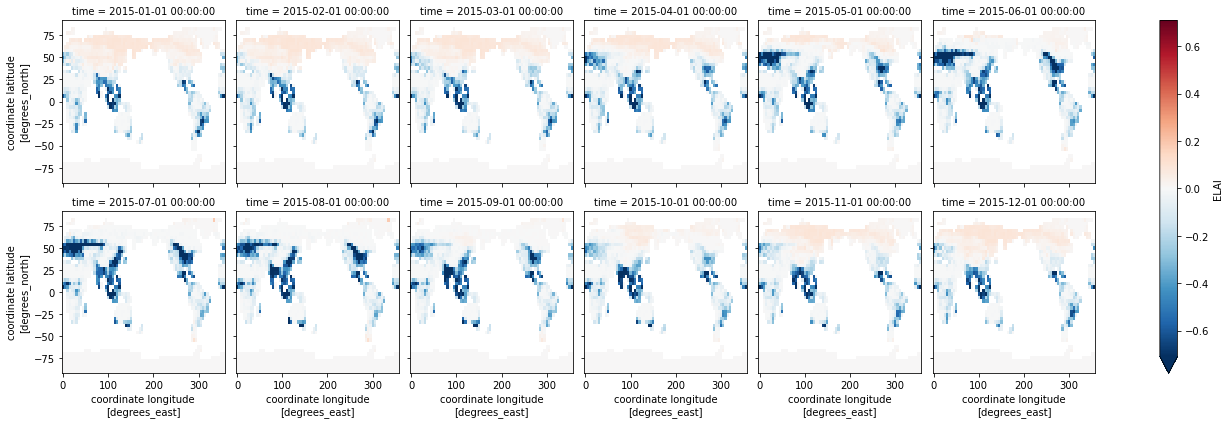

In [13]:
dsDiff.ELAI.plot(x='lon',y='lat',col="time", col_wrap=6, robust=True) ;

**Questions:** 
- What regions are LAI differences the greatest?
- What times of year is this true?
- Are the regions and times of largest differences the same as the differences in albedo? 

### Most of the differences in LAI seem to be in agricultural regions.  
Presently, FATESsp doesn't account for crop areas, which give it a lower LAI in places that have a large fraction of agricultural lands, especially during the growing season. This points to bigger challenges in how CTSM-FATES need to deal with crops, but it's something the CTSM and FATES teams are working on.

### 2.3 Calculating Time Series
As above, the plotting function we use here requires data to be 1D or 2D. Therefore, to plot a time series we either need to select a single point or average over an area.

#### 2.3.1 Time series at a single point
This example uses `.sel`, which functions similarly to the `.isel` function above, to select a single point in the Amazon. 

*What's the difference between `.sel` and `.isel`?*
- *`.sel` selects a value of a variable (e.g., latitude of -5)*
- *`.isel` selects an indexed point of a variable (e.g., the 6th point in the data vector)*

In the below examples, we'll also use subplots to see multiple variables in several panels

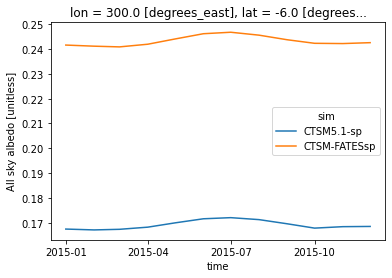

In [14]:
point = ds.sel(lon=300, lat=-5, method='nearest')
point.ASA.plot(hue='sim',x='time') ;

Similar to the maps above, there are differences in albedo between the simulations at this location. Let's add other variables to explore why we see differences at this location. 

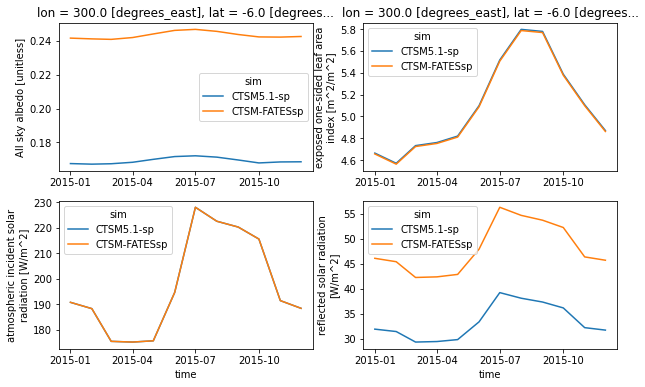

In [15]:
plt.figure(figsize=(10,6))
'''this first plot is the same as the one above'''
plt.subplot(221)
point.ASA.plot(hue='sim',x='time')
plt.xlabel(None)

'''now we'll look for potential sources of the difference'''
plt.subplot(222)
point.ELAI.plot(hue='sim',x='time') 
plt.xlabel(None)

plt.subplot(223)
point.FSDS.plot(hue='sim') 
plt.title(None)

plt.subplot(224)
point.FSR.plot(hue='sim') 
plt.title(None) ;

**Questions:** 
- What variables show differences?
- What variables are similar?
- How do the differences and similarities help to explain the differences in albedo?

#### 2.3.2 Global time series
There are many reasons why we may want to calculate globally integrated time series for particular variables.
This requires weighting the values from each grid cell by the total land area of individual grid cells. The example below does this for our dataset. 

#### First calculate the land weights:
- land area `la` that is the product of land fraction (fraction of land area in each grid cell) and the total area of the grid cell (which changes by latitude). Units are the same as area.
- land weights `lw`, the fractional weight that each grid makes to the global total, is calculated as the land area of each grid cell divided by the global sum of the land area.

The land weights are shown in the plot below. Note that these are larger near the equator, and smaller at the poles and along the coastline

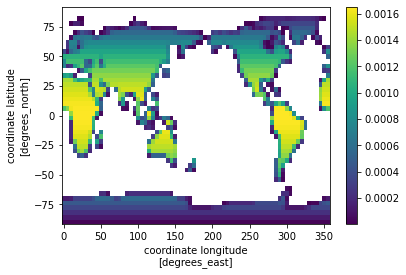

In [16]:
la = (ds.landfrac*ds.area).isel(time=0,sim=0).drop(['time','sim']) 
la = la * 1e6  #converts from land area from km2 to m2 
la.attrs['units'] = 'm^2'
lw = la/la.sum()
lw.plot() ;

#### Next, calculate and plot a global weighted sum
<div class="alert alert-block alert-info">

<b>NOTE:</b>  You will likely want to calculate global weighted sum for a variety of different variables. For variables that have area-based units (e.g. GPP, gC/<b>m^2</b>/s), you need to use the land area variable when calculating a global sum. <b> Remember to pay attention to the units and apply any necessary conversions!</b> Keep in mind that grid cell area is reported in km^2. 

</div>


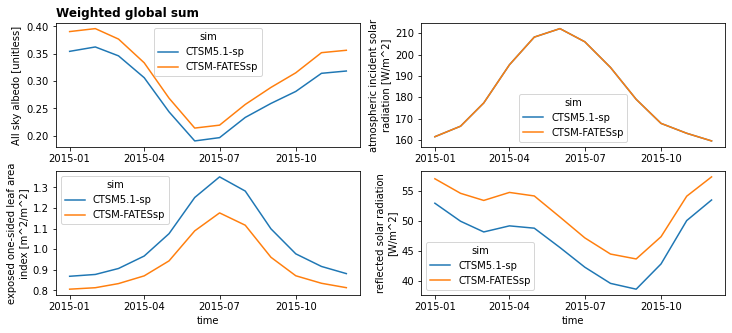

In [17]:
dsGlobalWgt = (ds * lw).sum(['lat','lon'])

plt.figure(figsize=(12,5))
plotVars = ['ASA','FSDS','ELAI','FSR']
for i in range(len(plotVars)):
    # First add metadata for plotting
    dsGlobalWgt[plotVars[i]].attrs['long_name'] = ds[plotVars[i]].attrs['long_name']
    dsGlobalWgt[plotVars[i]].attrs['units'] = ds[plotVars[i]].attrs['units']

    # then make plots
    plt.subplot(2,2,(i+1))
    dsGlobalWgt[plotVars[i]].plot(hue='sim')
    
    if i == 0:
        plt.title('Weighted global sum',loc='left', fontsize='large', fontweight='bold')
        
    if i<2:
        plt.xlabel(None)

---
### 2.4 Calculate an annual weighted mean and create customized plots
Annual averages require a different kind of weighting: the number of days per month.
This example creates python functions that allow you to easily calculate annual averages and create customized plots. 

<div class="alert alert-block alert-info">

<b>Python functions:</b> In python, creating a function allows us to use the same calculation numerous times instead of writing the same code repeatedly.
</div>


#### 2.4.1 Calculate monthly weights
The below code creates a function `weighted_annual_mean` to calculate monthly weights. Use this function any time you want to calculate weighted annual means.

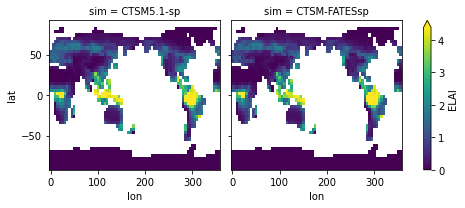

In [18]:
# create a function that will calculate an annual mean weighted by days per month
def weighted_annual_mean(array):
    mon_day  = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

# generate annual means
for i in range(len(plotVars)):
    temp = weighted_annual_mean(
        ds[plotVars[i]].chunk({"time": 12}))
    
    if i ==0:
        dsAnn = temp.to_dataset(name=plotVars[i])
    else:
        dsAnn[plotVars[i]] = temp

# Make a simple plot
dsAnn.ELAI.plot(x='lon',y='lat',col='sim',
               col_wrap=2, robust=True) ;

#### 2.4.2 Customized maps
Creating a function isn't necessary to plot maps, but this function, which uses python's `cartopy`, allows you to make several pretty maps in one figure.

Additional examples and information are available on the [cartopy website](https://scitools.org.uk/cartopy/docs/v0.15/index.html)

There are two code blocks below. The first block of code defines the function. The second code block creates the plot. 

In [19]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy

# Generate a function for making panel plots of maps
## many of these features are not required, but provide additional control over plotting
def map_function(da, cb=0, cmap='viridis', panel=None,  ax=None, 
                 title=None, vmax=None, vmin=None, units=None,nbins=200):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()

    # define the colormap, including the number of bins
    cmap = copy.copy(plt.get_cmap(cmap,nbins))
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)

    # set the bounds of your plot
    ax.set_extent([-180,180,-56,85], crs=ccrs.PlateCarree())

    # add title & panel labels
    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # add plotting features
    ax.coastlines()
    ocean = ax.add_feature(
        cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    
    # control colorbars on each plot & their location
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.03, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')

#### Now make the plot!

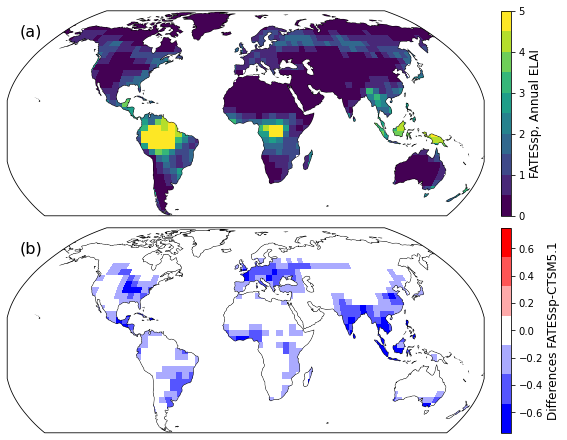

In [20]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = dsAnn.ELAI.isel(sim=1,time=0).drop(['sim','time'])
        map_function(plotData, ax=ax,cb=2,
                     panel='(a)', nbins=10,
                     vmax=5,vmin=0,
                     units='FATESsp, Annual ELAI')
    if i == 1:
        plotData = (dsAnn.ELAI.isel(sim=1,time=0)- \
                    dsAnn.ELAI.isel(sim=0,time=0))
        map_function(plotData, ax=ax,cb=2,panel='(b)',
                     units='Differences FATESsp-CTSM5.1',
                     cmap='bwr',nbins=7,
                     vmax=0.75,vmin=-0.75)    
                     
    i = i+1

## Extra credit challenge
If you have extra time & energy, try running through this notebook with other variables. Interesting options could include: 
- Canopy evaporation (`FCEV`) or 
- GPP (`FPSN` in CLM5.1-sp and `FATES_GPP` in FATES)

<div class="alert alert-block alert-warning">

<b>HINT:</b> pay attention to units for these challenges.  Variables may also need to be renamed and units modified to combine datasets (i.e., the GPP challenge is harder!).

</div>